In [1]:
!pip install shap==0.46.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.2/540.2 kB 16.4 MB/s eta 0:00:00
  Attempting uninstall: shap
    Found existing installation: shap 0.47.2
    Uninstalling shap-0.47.2:
      Successfully uninstalled shap-0.47.2


In [ ]:
# prompt: MOUNT

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# ======================= Load Data =======================

df_metabolites = pd.read_csv("/content/drive/MyDrive/MY THESIS/Thesis/df_metabolites_.csv")


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
import seaborn as sns
import shap
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle


In [5]:
# prompt: mount

from google.colab import drive # This line imports the 'drive' module
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# ======================= Encode Target Variable =======================
# ======================= Load Data =======================

df_metabolites = pd.read_csv("/content/drive/MyDrive/MY THESIS/Thesis/df_metabolites_.csv")
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_metabolites["TNBC_Subtype"])
X = df_metabolites.drop(columns=["TNBC_Subtype"]).values

# ======================= Standardize Features =======================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X).astype(np.float32)  # Ensure float32

# ======================= Train-Test Split =======================
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape for LSTM (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1])).astype(np.float32)
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1])).astype(np.float32)

# ======================= Build LSTM Model =======================
def build_lstm(X_train):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001))))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Bidirectional(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.001))))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.3))

    model.add(Dense(len(np.unique(y)), activation='softmax'))

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(learning_rate=1e-4),
        metrics=['accuracy']  # Only accuracy
    )
    return model

# ======================= Train Model =======================
model = build_lstm(X_train)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=150, batch_size=252,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, lr_scheduler])



Epoch 1/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.3600 - loss: 2.5138 - val_accuracy: 0.6114 - val_loss: 2.1136 - learning_rate: 1.0000e-04
Epoch 2/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6022 - loss: 1.8290 - val_accuracy: 0.7752 - val_loss: 1.8247 - learning_rate: 1.0000e-04
Epoch 3/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6953 - loss: 1.5818 - val_accuracy: 0.8128 - val_loss: 1.4468 - learning_rate: 1.0000e-04
Epoch 4/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7359 - loss: 1.4456 - val_accuracy: 0.8302 - val_loss: 1.2158 - learning_rate: 1.0000e-04
Epoch 5/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7570 - loss: 1.3701 - val_accuracy: 0.8382 - val_loss: 1.1253 - learning_rate: 1.0000e-04
Epoch 6/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7743 - loss: 1.3026 - val_accuracy: 0.8444 - val_loss: 1.0805 - learning_rate: 1.0000e-04
Epoch 7/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/st

##===Save Models for Comparabilty and Web App======

In [9]:
import torch.nn as nn

# Example of a Sequential model
model = nn.Sequential(
    nn.LSTM(input_size=128, hidden_size=64, num_layers=2),
    nn.Linear(64, 10)
)

# Now save the model
torch.save(model.state_dict(), '/content/drive/MyDrive/SAVED_MODELS/DEEPLEARNING/FULL_METABOLITES/BILSTM_M.pth')
print("BILSTM model saved successfully!")


BILSTM model saved successfully!


221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Classification Report:
              precision    recall  f1-score   support

         BL1       0.91      0.90      0.91      1399
         BL2       0.89      0.89      0.89      1518
         LAR       0.92      0.92      0.92      2226
           M       0.91      0.93      0.92      1913

    accuracy                           0.91      7056
   macro avg       0.91      0.91      0.91      7056
weighted avg       0.91      0.91      0.91      7056



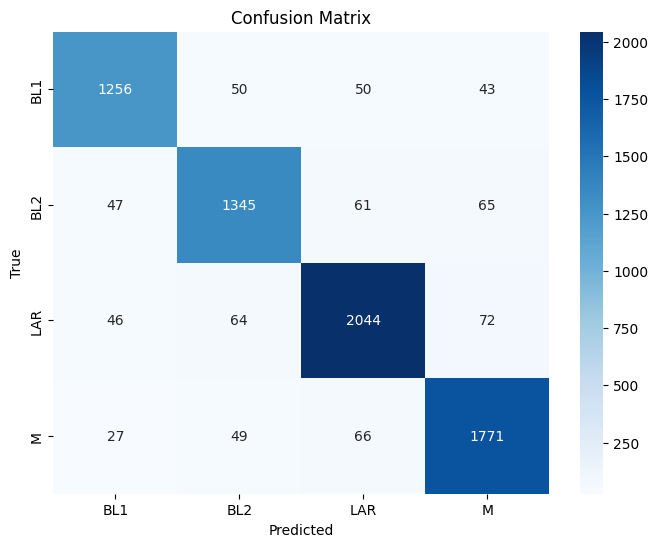

Accuracy: 0.909297052154195
Precision: 0.9092999871662176
Recall: 0.909297052154195
F1 Score: 0.9092596958054531


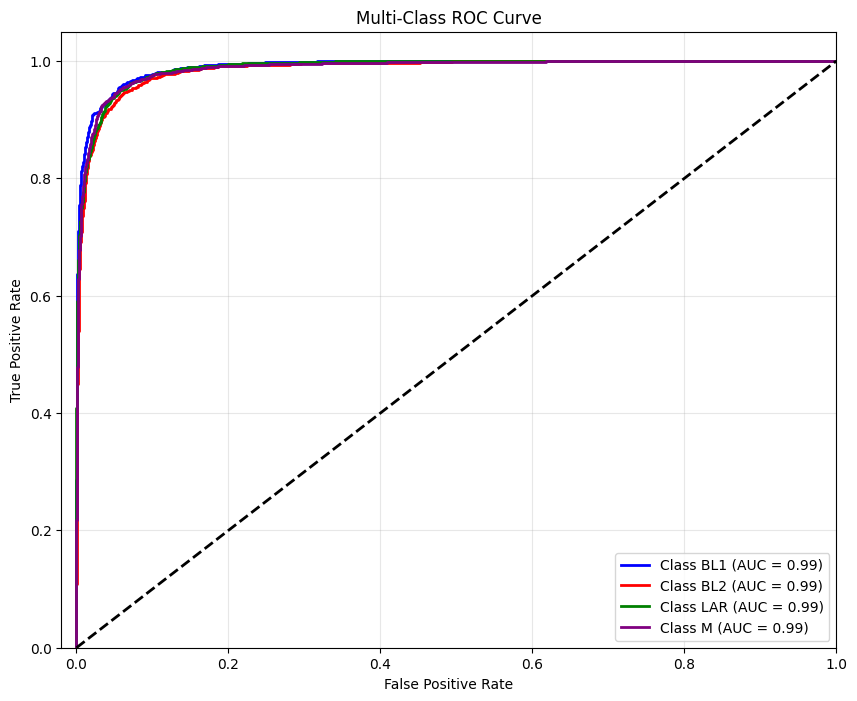


Macro-Averaged AUC: 0.9883


In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

# Define short labels
short_labels = ['BL1', 'BL2', 'LAR', 'M']

# ======================= Evaluate Model =======================
y_pred = np.argmax(model.predict(X_test), axis=1)
y_pred_proba = model.predict(X_test)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=short_labels))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='d',
            xticklabels=short_labels, yticklabels=short_labels)
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Additional Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

# ======================= ROC-AUC & Curve =======================
n_classes = len(short_labels)
y_test_one_hot = label_binarize(y_test, classes=range(n_classes))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'purple'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"Class {short_labels[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# Print overall macro/micro AUC
macro_auc = roc_auc_score(y_test_one_hot, y_pred_proba, average='macro', multi_class='ovr')
print(f"\nMacro-Averaged AUC: {macro_auc:.4f}")


In [ ]:
import shap

# Flatten input for SHAP (LSTM expects 3D, but SHAP needs 2D for KernelExplainer)
X_test_flat = X_test.reshape((X_test.shape[0], -1))
X_train_flat = X_train.reshape((X_train.shape[0], -1))

# Define prediction function
def predict_fn(x):
    x_reshaped = x.reshape((x.shape[0], 1, X_train.shape[2]))  # reshape back to 3D
    return model.predict(x_reshaped)

# Use a small background dataset for KernelExplainer
background = X_train_flat[np.random.choice(X_train_flat.shape[0], 100, replace=False)]
explainer = shap.KernelExplainer(predict_fn, background)

# Use a small sample for SHAP computation to avoid high computation time
X_shap_sample = X_test_flat[:50]

# Compute SHAP values
shap_values = explainer.shap_values(X_shap_sample)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
6838/6838 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
6838/6838 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6838/6838 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
6838/6838 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6838/6838 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
6838/6838 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6838/6838 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
6838/6838 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6838/6838 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6838/6838 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6838/6838 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6838/6838 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step
1/1 ━━━━━━━━━━━━

In [ ]:
# If shap_values is a list: (classes, samples, features)
print(f"SHAP shape (list of classes): {[v.shape for v in shap_values]}")

# Convert to array and take mean across classes to get overall importance
shap_array = np.array(shap_values)  # shape: (classes, samples, features)
shap_vals_all_classes = np.mean(np.abs(shap_array), axis=0)  # shape: (samples, features)

# Now shap_vals_all_classes and X_shap_sample have the same shape
print("SHAP values shape:", shap_vals_all_classes.shape)
print("X_shap_sample shape:", X_shap_sample.shape)

# ✅ Proceed to summary plot
import matplotlib.pyplot as plt
import seaborn as sns

# Compute top 10 global feature importances
shap_importance_all = np.mean(shap_vals_all_classes, axis=0)
top_10_idx = np.argsort(shap_importance_all)[-10:]
top_10_metabolites_all = np.array(feature_names)[top_10_idx][::-1]
top_10_importance_all = shap_importance_all[top_10_idx][::-1]

# Plot summary and bar chart
plt.figure(figsize=(16, 6))

# SHAP Summary plot
plt.subplot(1, 2, 1)
shap.summary_plot(shap_vals_all_classes, X_shap_sample, feature_names=feature_names, show=False, max_display=10)
plt.title("Overall SHAP Summary (Top 10 Features)", fontsize=14)

# Bar plot
plt.subplot(1, 2, 2)
sns.barplot(x=top_10_importance_all, y=top_10_metabolites_all, color='red', orient='h')
plt.title("Overall Feature Importance\n(Top 10 Metabolites)", fontsize=14)
plt.xlabel("Mean |SHAP value|")

plt.tight_layout()
plt.show()


SHAP shape (list of classes): [(4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50), (4, 50)]
SHAP values shape: (4, 50)
X_shap_sample shape: (4, 1, 70)


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

<Figure size 1600x600 with 0 Axes>

In [ ]:
# Example fix
X_shap_sample_flat = X_test_flat.reshape((X_test_sample.shape[0], -1))  # Flatten if needed
print("Fixed X shape:", X_shap_sample_flat.shape)


NameError: name 'X_test_sample' is not defined

In [ ]:
# Confirm original SHAP values shape (should be: classes, samples, features)
print("Original SHAP shape:", shap_values.shape)

# Step 1: Take mean across classes to get average impact per feature
shap_vals_all_classes = np.mean(np.abs(shap_values), axis=0)  # shape: (samples, features)
print("After mean across classes:", shap_vals_all_classes.shape)

# Step 2: Check against X_shap_sample_flat
print("Shape of X_shap_sample_flat:", X_shap_sample_flat.shape)


Original SHAP shape: (70, 4, 50)
After mean across classes: (4, 50)
Shape of X_shap_sample_flat: (4, 70)


In [ ]:
plt.figure(figsize=(16, 6))

# Summary plot
plt.subplot(1, 2, 1)
shap.summary_plot(shap_vals_all_classes, X_shap_sample_flat, feature_names=feature_names,
                  show=False, plot_type='dot', max_display=10)
plt.title("Overall SHAP Summary (Top 10 Features)", fontsize=14)

# Bar plot
plt.subplot(1, 2, 2)
sns.barplot(x=top_10_importance_all_sorted, y=top_10_metabolites_all_sorted, color='red', orient='h')
plt.title('Overall Feature Importance\n(Top 10 Metabolites)', fontsize=14)
plt.xlabel('Mean |SHAP value|', fontsize=12)

plt.tight_layout()
plt.show()


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

<Figure size 1600x600 with 0 Axes>


--- SHAP Summary for Subtype: Basal-like 2 (BL2) ---


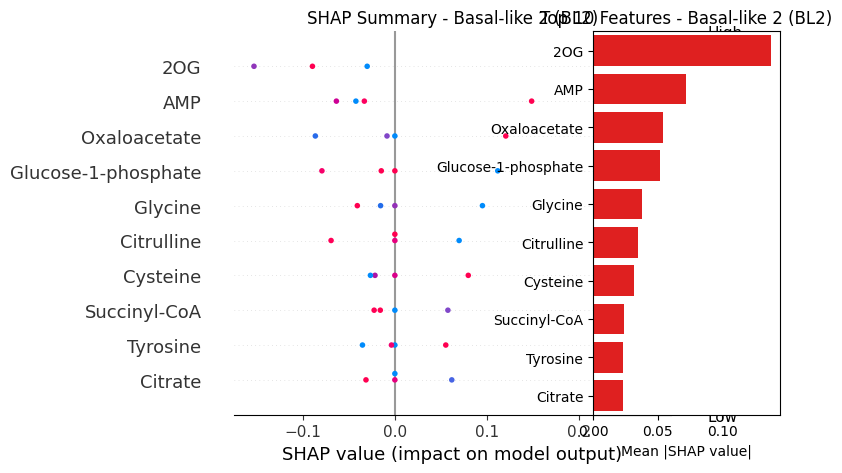


--- SHAP Summary for Subtype: Basal-like 1 (BL1) ---


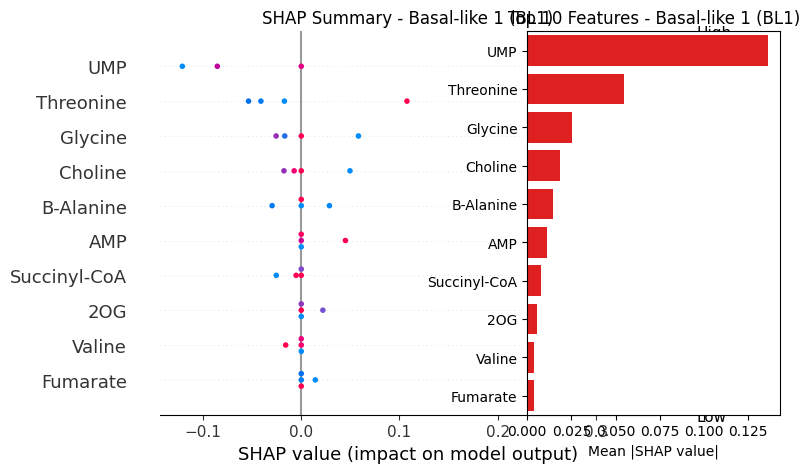


--- SHAP Summary for Subtype: Mesenchymal (M) ---


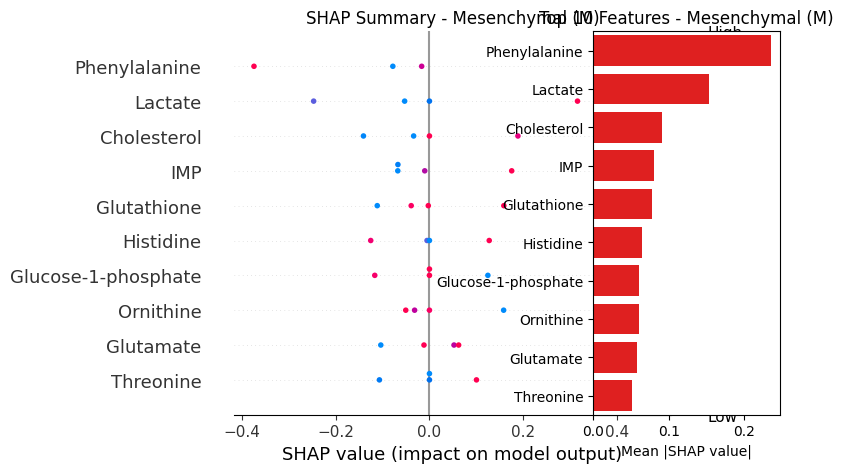


--- SHAP Summary for Subtype: Luminal Androgen Receptor (LAR) ---


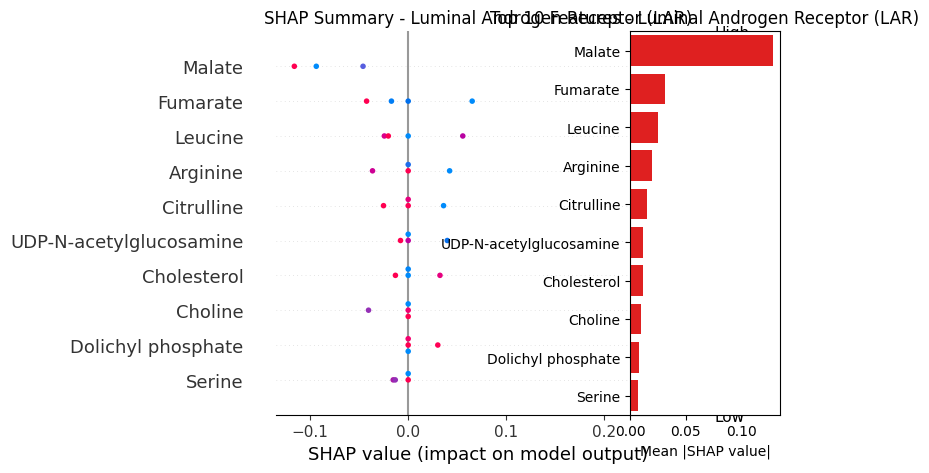

In [ ]:
# ==================== Loop over each Subtype for SHAP Summary and Feature Importance ====================
for i, subtype in enumerate(subtype_names):
    print(f"\n--- SHAP Summary for Subtype: {subtype} ---")

    # Compute the mean absolute SHAP value for ranking the features (for this specific subtype)
    shap_vals_subtype = shap_values[i]  # shape: (samples, features)
    mean_shap_subtype = np.mean(np.abs(shap_vals_subtype), axis=0)

    # Get indices for the top 10 features for this subtype
    top_indices_subtype = np.argsort(mean_shap_subtype)[-10:][::-1]

    # Filter SHAP values and features for top 10
    shap_values_top_subtype = shap_vals_subtype[:, top_indices_subtype]

    # Use the reshaped data used for SHAP (X_shap_sample_flat here)
    X_test_top_subtype = X_shap_sample_flat[:, top_indices_subtype]

    top_feature_names_subtype = np.array(feature_names)[top_indices_subtype]

    # ==================== Plot SHAP Summary and Feature Importance for Subtype ====================
    plt.figure(figsize=(14, 6))

    # SHAP Summary Plot for top 10 features (left)
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
    shap.summary_plot(shap_values_top_subtype, X_test_top_subtype, feature_names=top_feature_names_subtype, plot_type='dot', show=False)
    plt.title(f"SHAP Summary - {subtype}")

    # Red bar plot of top 10 features (right)
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
    top_importances_subtype = mean_shap_subtype[top_indices_subtype]
    sns.barplot(x=top_importances_subtype, y=top_feature_names_subtype, color='red')
    plt.title(f"Top 10 Features - {subtype}")
    plt.xlabel("Mean |SHAP value|")

    plt.tight_layout()
    plt.show()



Class 0: BL1


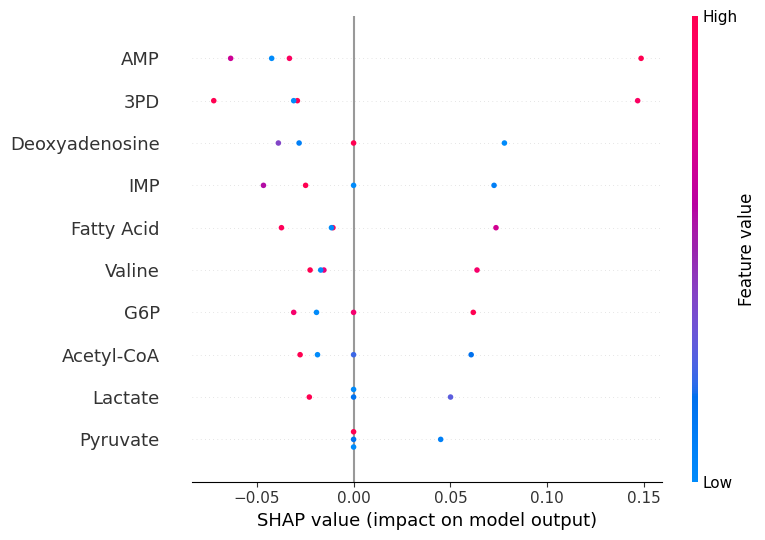


Class 1: BL2


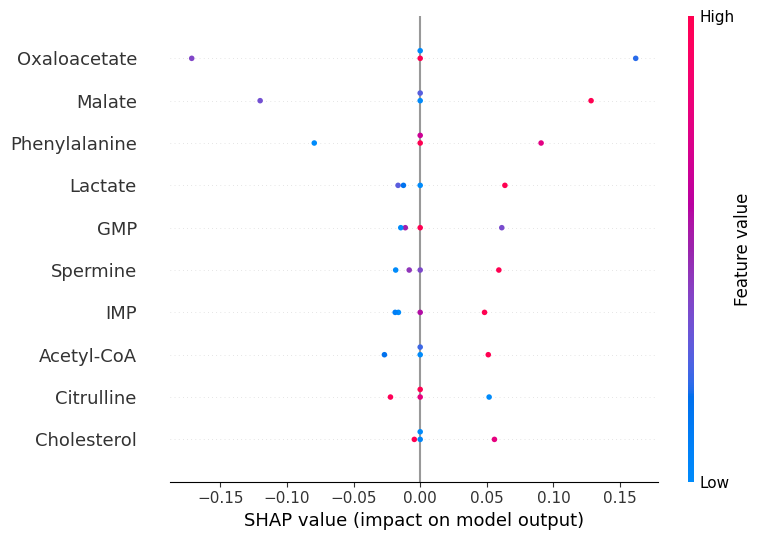


Class 2: LAR


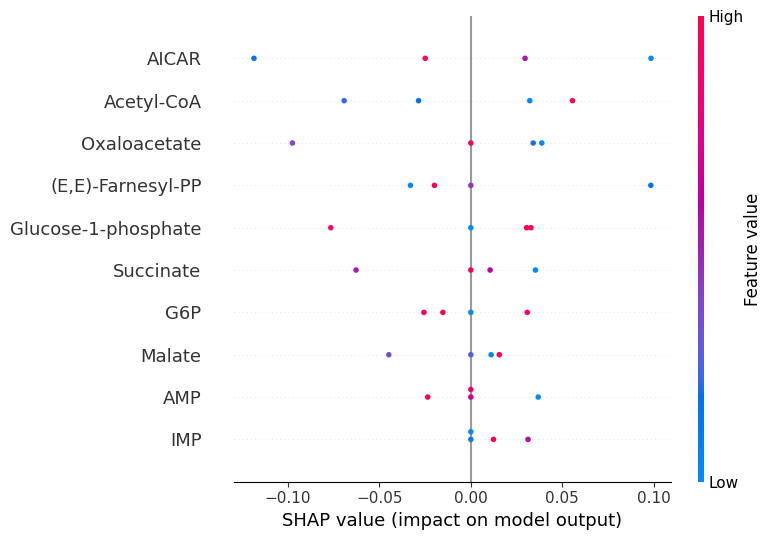


Class 3: M


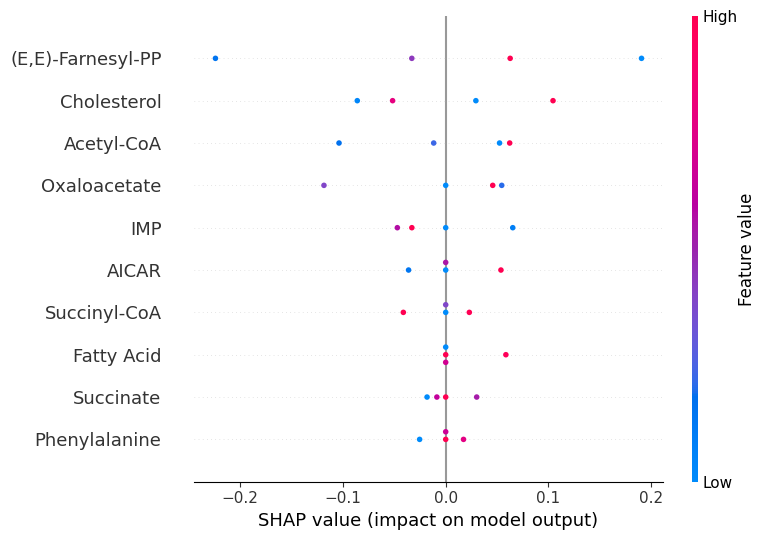

In [ ]:
# Sample 4 examples for SHAP plotting
X_shap_sample = X_test[:4]
X_shap_sample_flat = X_shap_sample.reshape((X_shap_sample.shape[0], X_shap_sample.shape[2]))  # shape: (4, 70)

# Loop through each class
for i, class_name in enumerate(['BL1', 'BL2', 'LAR', 'M']):
    print(f"\nClass {i}: {class_name}")

    # Transpose SHAP values to (samples, features)
    shap_vals = shap_values[i].T  # shape: (4, 70)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Left: SHAP summary plot
    plt.sca(axes[0])
    shap.summary_plot(
        shap_vals,
        X_shap_sample_flat,
        feature_names=feature_names,
        show=False,
        plot_type="dot",
        color_bar=True,
        max_display=10
    )
    axes[0].set_title(f"SHAP Summary - {class_name}", fontsize=14)

    # Right: Top 10 Feature Importance bar plot
    mean_abs_shap = np.abs(shap_vals).mean(axis=0)
    top10_idx = np.argsort(mean_abs_shap)[-10:][::-1]
    top10_features = np.array(feature_names)[top10_idx]
    top10_values = mean_abs_shap[top10_idx]

    axes[1].barh(top10_features, top10_values, color='red')
    axes[1].set_title(f"Top 10 Features - {class_name}", fontsize=14)
    axes[1].set_xlabel("Mean |SHAP| Value")
    axes[1].invert_yaxis()

    plt.tight_layout()
    plt.show()


# ====================== USING UMAP DATAFRAME =======================

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
import seaborn as sns
import shap
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle


In [11]:
# ======================= Load Data =======================

df_UMAP = pd.read_csv("/content/drive/MyDrive/MY THESIS/Thesis/metabolites_umap_training.csv")


In [ ]:

# ======================= Data Prep =======================
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_UMAP["TNBC_Subtype"])
X = df_UMAP.drop(columns=["TNBC_Subtype"]).values
feature_names = df_UMAP.drop("TNBC_Subtype", axis=1).columns.tolist()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X).astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1])).astype(np.float32)
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1])).astype(np.float32)

# ======================= Model =======================
def lstm(X_train):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001))))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Bidirectional(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.001))))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.3))

    model.add(Dense(len(np.unique(y)), activation='softmax'))

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(learning_rate=1e-4),
        metrics=['accuracy']
    )
    return model

model = lstm(X_train)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=150, batch_size=252,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, lr_scheduler])

# ======================= Evaluation =======================
y_pred = np.argmax(model.predict(X_test), axis=1)
y_pred_proba = model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='d',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

# ROC-AUC
n_classes = len(label_encoder.classes_)
y_test_one_hot = label_binarize(y_test, classes=range(n_classes))
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'purple', 'orange', 'cyan'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"Class {label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

macro_auc = roc_auc_score(y_test_one_hot, y_pred_proba, average='macro', multi_class='ovr')
print(f"\nMacro-Averaged AUC: {macro_auc:.4f}")

Epoch 1/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.5373 - loss: 1.8176 - val_accuracy: 0.8965 - val_loss: 1.8673 - learning_rate: 1.0000e-04
Epoch 2/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8918 - loss: 0.9254 - val_accuracy: 0.9627 - val_loss: 1.4482 - learning_rate: 1.0000e-04
Epoch 3/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9229 - loss: 0.7958 - val_accuracy: 0.9735 - val_loss: 0.9205 - learning_rate: 1.0000e-04
Epoch 4/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9320 - loss: 0.7345 - val_accuracy: 0.9758 - val_loss: 0.6728 - learning_rate: 1.0000e-04
Epoch 5/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9433 - loss: 0.6863 - val_accuracy: 0.9789 - val_loss: 0.5934 - learning_rate: 1.0000e-04
Epoch 6/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9464 - loss: 0.6554 - val_accuracy: 0.9819 - val_loss: 0.5547 - learning_rate: 1.0000e-04
Epoch 7/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/st

##===Save Models for Comparabilty and Web App======

In [ ]:
import torch.nn as nn

# Example of a Sequential model
model = nn.Sequential(
    nn.LSTM(input_size=128, hidden_size=64, num_layers=2),
    nn.Linear(64, 10)
)

# Now save the model
torch.save(model.state_dict(), '/content/drive/MyDrive/SAVED_MODELS/DEEPLEARNING/UMAP/BILSTM_M.pth')
print("BILSTM model saved successfully!")
